# GMM-EM (Improved initialization with K-Means)

In this notebook we will improve the initialization of the GMM-EM algorithm using the K-Means algorithm.

We will run the K-Means over the dataset and use the results to calculate means $\mu_k$, covariance matrices $\Sigma_k$ and mixing coefficients $\pi_k$, using them as initialization parameters for the GMM-EM algorithm.

We will compare the standar initialization against the initialitzation with 3 versions of K-Means (Vanilla KMeans, KMeans++ and pillarKMeans)

## Libraries and helper functions

In [35]:
# Import the libraries that we will need.
from typing import NewType
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import pprint
pp = pprint.PrettyPrinter(indent=4)
from scipy.stats import multivariate_normal
from sklearn.metrics.cluster import contingency_matrix
import pandas as pd
from functools import wraps
from time import time

In [36]:
# Count the execution time of the algorithms.
def calculate_time(f):
    @wraps(f)
    def chronometer(*args, **kwargs):
        t_initial = time()
        output = f(*args, **kwargs)
        t_final = time()
        print('-> Elapsed time (in seconds): {}'.format(t_final - t_initial))
        return output
    return chronometer

In [37]:
# Generate .
def generate_dataset(n_samples, centers, n_features, random_state, transform_data=False):
  X, Y = make_blobs(n_samples=n_samples, centers=centers, n_features=n_features, random_state=random_state)
  # Transform data.
  if transform_data:
    X = np.dot(X, [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]])
  # Plot dataset.
  fig, ax = plt.subplots(figsize=(15,10))
  ax.scatter(X[:,0], X[:,1], c=Y)
  return X,Y

In [38]:
# Results of the GMM.
def res_gmm(gmm, x, y, k, initial, iterations, betas=[1.0]):
  c_points, sigmas, probs = gmm.EM(k,x,y,gmm.initParams(initial)['c_points'], gmm.initParams(initial)['cov'], 'same', iterations, betas)
  gmm.printGraphic(k, x, y, c_points, sigmas, probs) # Print the plot.

In [39]:
# Metrics.
def e_score(mat):
    maxs = np.zeros(mat.shape[0])
    for l in np.arange(mat.shape[0]):
        maxs[l] = np.max(mat[l, :])
    maxs = np.sum(maxs)
    return 1 - maxs / np.sum(mat)

def p_score(mat):
    totals = np.sum(mat, 0) / np.sum(mat)
    precision_kl = np.zeros(mat.shape[1])
    for k in np.arange(mat.shape[1]):
        precision_kl[k] = np.max(mat[:, k] / np.sum(mat[:, k]))
    return np.sum(totals * precision_kl)

def precision_score(mat, l, k):
    return mat[l,k]/np.sum(mat[:,k])

def recall_score(mat, l, k):
    return mat[l,k]/np.sum(mat[l,:])

def f1_specific_score(mat, l, k):
    prec = precision_score(mat, l, k)
    rec = recall_score(mat, l, k)
    if (prec+rec)==0:
        return 0
    else:
        return 2*prec*rec/(prec+rec)

def f1_score(mat):
    totals = np.sum(mat, 1) / np.sum(mat)
    f1 = np.zeros(mat.shape)
    for l in np.arange(mat.shape[0]):
        for k in np.arange(mat.shape[1]):
            f1[l, k] = f1_specific_score(mat, l, k)
    f1 = np.sum(totals * np.max(f1, axis=1))
    return f1

## Datasets

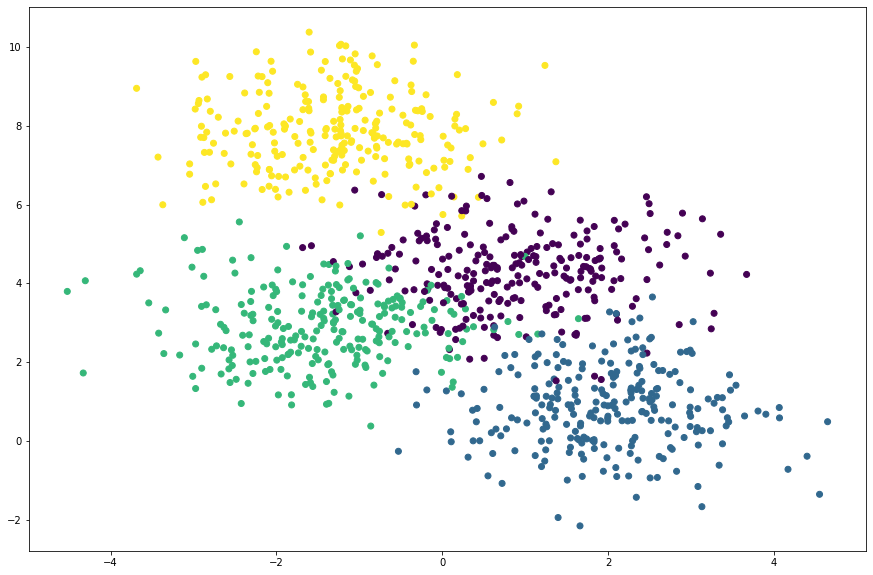

In [40]:
# Dataset 1
X, Y = generate_dataset(n_samples=1000, centers=4, n_features=2, random_state=0)

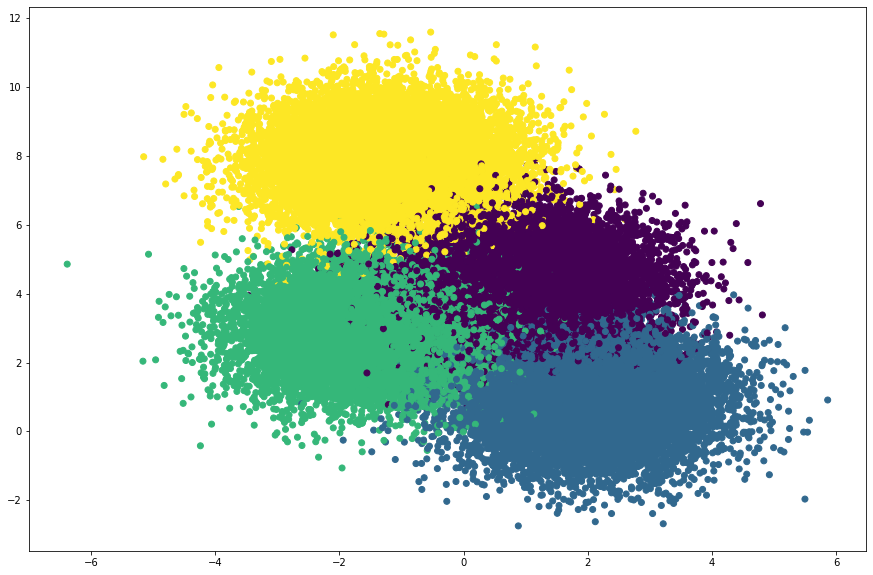

In [41]:
# Dataset 2
X2, Y2 = generate_dataset(n_samples=50000, centers=4, n_features=2, random_state=0)

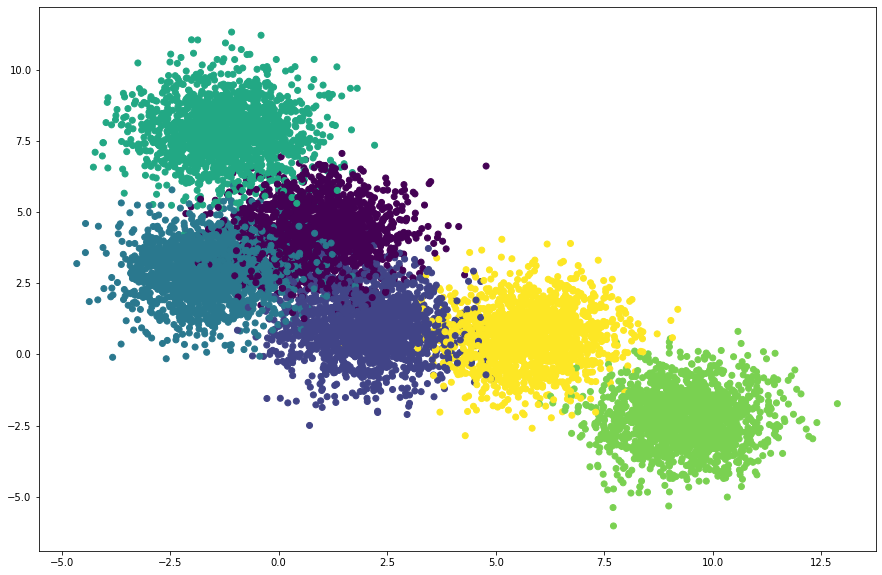

In [42]:
# Dataset 3
X3, Y3 = generate_dataset(n_samples=10000, centers=6, n_features=2, random_state=0)

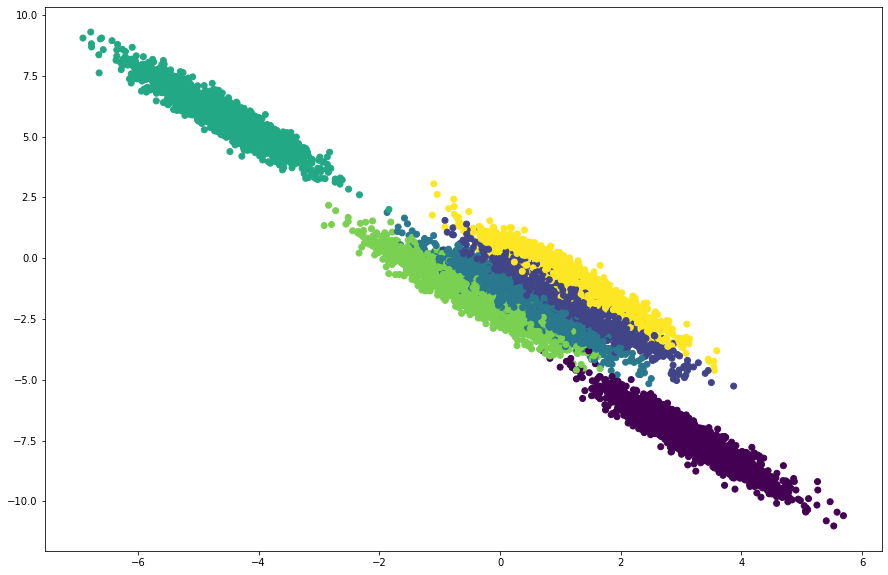

In [43]:
# Dataset 4
X4, Y4 = generate_dataset(n_samples=10000, centers=6, n_features=2, random_state=2, transform_data=True)

## Class K-Means (Vanilla, K-Means++, Pillar K-Means)


In [44]:
class kmeans_models(object):
    def __init__(self, data, real_labels, n_clusters, method):
        (self.n, _) = data.shape
        self.data = data
        self.clusters = n_clusters
        self.y_real = real_labels
        self.method = method
        self.a = 0.25 # alpha value
        self.b = 0.33 # beta value
        
        # Select method to get centroids
        # Random
        if self.method == 0:
            self.centroids = self.get_centers(self.data, self.clusters)
        # K-Means++
        elif self.method == 1:
            self.centroids = 'k-means++'
        # Pillar K-Means
        elif self.method == 2:       
            self.centroids_pos, self.centroids = self.get_centers_pillar(self.data)
        
        # K-Means
        self.kmeans = KMeans(n_clusters=self.clusters, init=self.centroids, n_init=1)
        
    ### Get Random Centroids ###
    def get_centers(self, da, cl):
        self.Dx = da
        self.K = cl
        cDx = np.zeros(self.K*self.Dx.shape[1])
        cDx.shape = (self.K,self.Dx.shape[1])
        for d in np.arange(self.Dx.shape[1]):
            cDx[:,d] = self.random_sample_float(self.K, np.min(self.Dx[:,d]), np.max(self.Dx[:,d]))
        return cDx

    # random sample
    def random_sample_float(self, n_, mi_, ma_):
        self.n = n_
        self.mi = mi_
        self.ma = ma_
        return (self.ma - self.mi) * np.random.random_sample(self.n) + self.mi

    ### Get Pillar Centroids ###
    def get_centers_pillar(self, x):
        c = [] # c: idx number of centroids
        sx = [] # sx: x which selected in the sequence of process
        m = np.mean(x, axis=0)
        d = self.dis(x, m) # d: distance metric between one point and the others (init with global mean point)
        dm = np.zeros((self.n, )) # dm: accumulated distance metric
        dmax, argmax = self.get_dmax(d)
        nmin = self.a * self.n / self.clusters
        nbdis = self.b * dmax
        i = 1
        dm += d
        while i <= self.clusters:
            dmmax, arg = self.get_dmax(dm)
            new_point = x[arg]
            sx.append(arg)
            d = self.dis(x, new_point)
            no = sum(d <= nbdis)
            dm[arg] = 0
            if no < nmin:
                continue
            for pos in sx:
                d[pos] = 0
            c.append(arg)
            dm += d
            i += 1
        c_value = np.concatenate([[x[p]] for p in c], axis=0)
        return c, c_value

    # update d
    def dis(self, x, m):
        return np.sqrt(np.sum(np.square(x - m), axis=1)).reshape((self.n, ))

    # get the next candidate
    def get_dmax(self, d):
        return d.max(), np.argmax(d)
    
    ### Get Variables for GMM ###
    def get_variables(self):
        y_pred = self.kmeans.fit_predict(self.data)
        c = self.kmeans.cluster_centers_
        # Get covariance matrix list
        sigmas = []
        for k in np.arange(self.clusters):
            mask = np.where(y_pred == k)
            sigmas.append(np.cov(self.data[mask][:,0], self.data[mask][:,1]))
        return {'cov': sigmas, 'c_points': c}

    ### Get Cluster Result ###
    def get_result(self):
        # Initial centers
        if self.method == 0:
          print('--- Centroids: random ---\n')
          print('· Initial centers: \n', self.centroids,'\n')
        elif self.method == 1:
          print('--- Centroids: kmeans++ ---\n')
        elif self.method == 2:       
          print('--- Centroids: pillarkmeans ---\n')
          print('· Initial centers: \n', self.centroids,'\n')
        
        # Final centers
        y_pred = self.kmeans.fit_predict(self.data)
        c = self.kmeans.cluster_centers_
        print('· Final centers:\n', c,'\n')

        # Metrics
        mC = contingency_matrix(self.y_real,y_pred)
        mE = e_score(mC)
        mP = p_score(mC)
        mF1 = f1_score(mC)
        print('-> Metrics')
        print('· Confusion matrix:\n', mC)
        print(f'· Error = {mE}')
        print(f'· The purity of the resulting cluster is = {mP}')
        print(f'· F1 value = {mF1}\n')

        # Plot graphic
        print('* Blue circles (initial centers) and Red stars (final centers)')
        fig, ax = plt.subplots(figsize=(10,5))
        ax.scatter(self.data[:,0],self.data[:,1], c=y_pred)
        ax.scatter(c[:,0],c[:,1], marker='*', s=200, c='r')
        if self.method != 1:
            ax.scatter(self.centroids[:,0],self.centroids[:,1], marker='o', s=200, c='b')

### Comparison between K-Means models

--- Centroids: random ---

· Initial centers: 
 [[ 1.20862339 -1.19083461]
 [ 7.42138628  4.50765547]
 [ 4.81607026 10.32084167]
 [ 6.81032867 11.21982124]
 [ 2.88454354 -4.36459175]
 [ 3.10115493  2.97706277]] 

· Final centers:
 [[ 2.05148255  1.0336854 ]
 [ 5.76616791  0.63390268]
 [-1.16479551  7.76665994]
 [10.08484067 -2.29568417]
 [ 8.46688403 -2.22509773]
 [-0.44157225  3.57295536]] 

-> Metrics
· Confusion matrix:
 [[ 138    1   80    0    0 1448]
 [1559   56    0    0    0   52]
 [  37    0    4    0    0 1626]
 [   0    0 1637    0    0   30]
 [   0    4    0  858  804    0]
 [  45 1590    0    0   31    0]]
· Error = 0.12819999999999998
· The purity of the resulting cluster is = 0.8074
· F1 value = 0.7974064783366615

* Blue circles (initial centers) and Red stars (final centers)


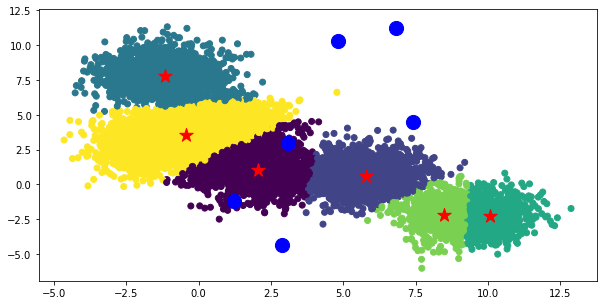

In [80]:
# Vanilla K-Means
vkm = kmeans_models(data=X3, real_labels = Y3, n_clusters=6, method = 0)
vkm.get_result()

--- Centroids: kmeans++ ---

· Final centers:
 [[ 0.97574834  4.32905881]
 [-1.65102758  2.87259314]
 [ 5.79314693  0.60961138]
 [ 9.3218227  -2.27667378]
 [-1.25621131  7.83197133]
 [ 2.04639767  0.85606102]] 

-> Metrics
· Confusion matrix:
 [[1495  101    1    0   21   49]
 [  68   17   55    0    0 1527]
 [ 124 1511    0    0    4   28]
 [  35   10    0    0 1622    0]
 [   0    0   13 1653    0    0]
 [   1    0 1604   12    0   49]]
· Error = 0.05879999999999996
· The purity of the resulting cluster is = 0.9412
· F1 value = 0.9413462668437177

* Blue circles (initial centers) and Red stars (final centers)


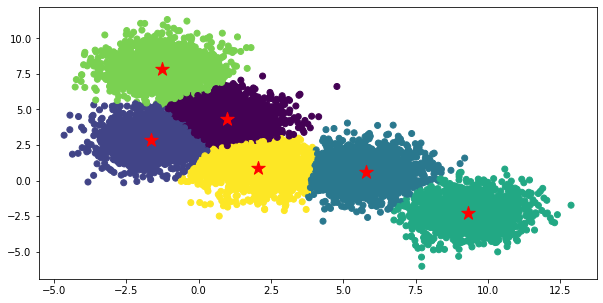

In [46]:
# K-Means++
km_pp = kmeans_models(data=X3, real_labels = Y3, n_clusters=6, method = 1)
km_pp.get_result()

--- Centroids: pillarkmeans ---

· Initial centers: 
 [[12.30401308 -2.96291899]
 [-3.24528922 10.24123062]
 [ 7.71248064 -6.02545492]
 [-1.08554585 11.32701038]
 [12.87156531 -1.72939508]
 [-3.82726276 -0.09999606]] 

· Final centers:
 [[ 9.3218227  -2.27667378]
 [-1.25677386  7.83310745]
 [ 2.04874288  0.85615533]
 [ 0.97237944  4.32933556]
 [ 5.79421924  0.60885469]
 [-1.65200914  2.8699332 ]] 

-> Metrics
· Confusion matrix:
 [[   0   21   49 1496    1  100]
 [   0    0 1527   68   55   17]
 [   0    4   28  124    0 1511]
 [   0 1622    0   35    0   10]
 [1653    0    0    0   13    0]
 [  12    0   50    1 1603    0]]
· Error = 0.05879999999999996
· The purity of the resulting cluster is = 0.9412
· F1 value = 0.9413492904554771

* Blue circles (initial centers) and Red stars (final centers)


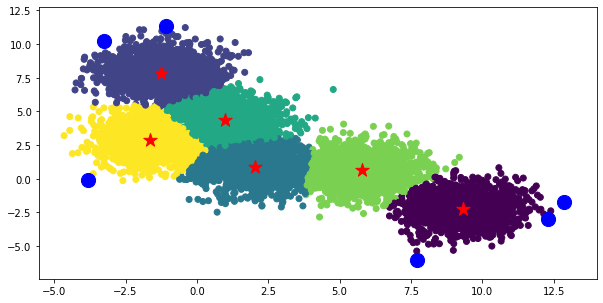

In [47]:
# Pillar K-Means
pillar_km = kmeans_models(data=X3, real_labels = Y3, n_clusters=6, method = 2)
pillar_km.get_result()

**Coclusions**

The metrics results of K-Means++ and Pillar K-Means are very similar and both are much better than Vanilla K-Means. The result of  random centroids initizialization it will depend depend of how good the centroids obtained are and this is done randomly, so in every execute we can obtain different results.

## Clase GMM

In [48]:
I_initParams = NewType('initParams', {'probs': list, 'centers': list, 'cov_mat': list})

class GMM():
  def __init__(self, X, Y, K):
    self.X = X
    self.Y = Y
    self.K = K
  
  """Return initialization params for GMM, params are different depending on 'i' argument
        # Argument
            i (str): Initialization type
        # Returns
            Params for GMM initialization
        """

  def initParams(self, i: str) -> I_initParams:
    if i == 'random':
      return {
          'probs': np.ones(self.K)/self.K,
          'cov': np.array([np.matrix(np.diag( 0.1 * np.ones( self.X.shape[1] ) )) for x in np.arange(k)]),
          'c_points': self.randomCenters(self.K, self.X)
      }
    elif i == 'kmeans':
      km = kmeans_models(data=self.X, real_labels=self.Y, n_clusters=self.K, method = 0)
      return {
          'probs': np.ones(self.K)/self.K,
          'cov': km.get_variables()['cov'],
          'c_points': km.get_variables()['c_points']
      }
    elif i == 'kmeans++':
      km = kmeans_models(data=self.X, real_labels=self.Y, n_clusters=self.K, method = 1)
      return {
          'probs': np.ones(self.K)/self.K,
          'cov': km.get_variables()['cov'],
          'c_points': km.get_variables()['c_points']
      }
    elif i == 'pillarkmeans':
      km = kmeans_models(data=self.X, real_labels=self.Y, n_clusters=self.K, method = 2)
      return {
          'probs': np.ones(self.K)/self.K,
          'cov': km.get_variables()['cov'],
          'c_points': km.get_variables()['c_points']
      }

  """Return random centers
        # Argument
            K (number): Number of centers
            X (matrix): Dataset elements
        # Returns
            Random centers
        """
  def randomCenters(self,K,X):
    cDx = np.zeros(K*X.shape[1]).reshape(K,X.shape[1])

    def random_sample_float(n, mi, ma):
        return (ma - mi) * np.random.random_sample(n) + mi

    for d in np.arange(X.shape[1]):
        cDx[:,d] = random_sample_float(K, np.min(X[:,d]), np.max(X[:,d]))
    return cDx

    """Print graphic
        # Argument
            K (number): Number of clusters
            X (matrix): Dataset elements
            Y (Array): Dataset Labels
            c_points (Array): Center points taken from kmeans
            sigmas (Array): Covariance matrix taken from kmeans
        # Returns
            Params form k means
        """

  def printGraphic(self, K, X, Y, c_points, sigmas, probs):
    x, y = np.mgrid[(np.min(X[:,0])-0.1):(np.max(X[:,0])+0.1):.01, (np.min(X[:,1])-0.1):(np.max(X[:,1])+0.1):.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y

    fig, ax = plt.subplots(figsize=(10,5))
    for k in np.arange(K):
        rv = multivariate_normal(mean=c_points[k,:], cov=sigmas[k])
        ax.contour(x, y, rv.pdf(pos), levels=10, linewidths=1, colors='k', alpha=0.1)
        ax.contourf(x, y, rv.pdf(pos), levels=10, cmap="RdBu_r",alpha=0.1)

    ax.scatter(X[:,0],X[:,1], s=probs+5, c=Y)
    ax.scatter(c_points[:,0],c_points[:,1], marker='*', s=200, c='g')

  """Apply EM algorithm for GMM
        # Argument
            K (number): Number of clusters
            X (matrix): Dataset elements
            Y (Array): Dataset Labels
            c_points (Array): Center points taken from kmeans
            sigmas (Array): Covariance matrix taken from kmeans
            n_iterations: Number of iterations
        # Returns
            New params returned by EM for GMM algorithm 
        """

  @calculate_time
  def EM(self, K, X, Y, c_points, sigmas, probs, n_iterations, betas=[1.0]):
    # Manage probs
    if probs == 'same':
      probs =  np.ones(self.K)/self.K

    # Save vector where we are going to save the probabilistic allocation
    # of each element in the cluster (z_ik)
    Dy_probs = np.zeros((X.shape[0], K))

    # True if you want to plot intermediate states
    draw = False
    freq_draw = 10

    it = 0

    while it < n_iterations:
      # When beta is [1.0] it does not use DAEM, with DAEM it will start with a beta between 0 and 1, will go a bit bigger than one, will go down again to 1.0, and will stay there.
      for beta in betas:

        # Aux vector to save centers of last iteration in order
        # to identify convergence
        cDx_ant = c_points.copy()
        
        # PASO E:
        # Calculate allocation to components (z_ik)
        for k in np.arange(K):
            Dy_probs[:,k] = probs[k] * multivariate_normal.pdf(X, mean=c_points[k,:], cov=sigmas[k], allow_singular=True)
        Dy_probs = np.power(Dy_probs, beta)/np.sum(np.power(Dy_probs, beta),axis=1)[:,None]

        # PASO M:
        # - a: Calculate new centers of K components
        for k in range(K):
            c_points[k,:] = np.sum(Dy_probs[:,k,None]*X,axis=0)/np.sum(Dy_probs[:,k])

        # - b: Calculate covariance matrix (sigma) of K components
        for k in range(K):
            sigmas[k] = np.sum([Dy_probs[i,k]* np.dot(X[i,:,None]-c_points[k,:,None], (X[i,:,None]-c_points[k,:,None]).transpose()) for i in np.arange(X.shape[0])], axis=0) / np.sum(Dy_probs[:,k])
        # - c: Calculate importance coeficients of the different components
        probs = np.sum(Dy_probs,axis=0)/X.shape[0]

        if draw and (it % freq_draw) == 0:
            # Draw plot with final result
            self.printGraphic(K, X, Y, c_points, sigmas, Dy_probs)

        it += 1

      betas = [1.0]
  
      if np.allclose(c_points, cDx_ant, rtol=1e-02):
          break
        
    print('-> Iterations untill convergence: {}\n'.format(it))

    # Metricas
    Dy_pred = [np.argmax(x) for x in Dy_probs]
    mC = contingency_matrix(self.Y,Dy_pred)
    mE = e_score(mC)
    mP = p_score(mC)
    mF1 = f1_score(mC)
        
    print('-> Métricas')
    print('· Confusion matrix:\n', mC)
    print(f'· Error value = {mE}')
    print(f'· Clustering purity = {mP}')
    print(f'· F1 value = {mF1}\n')

    return c_points, sigmas, probs

## Resultados


### Dataset 1

In [49]:
# Init GMM class
x = X
y = Y
k = 4
gmm = GMM(x, y, k)

-> Iterations untill convergence: 15

-> Métricas
· Confusion matrix:
 [[ 15   2 218  15]
 [  0   0 249   1]
 [  0   1  27 222]
 [  0 239  11   0]]
· Error value = 0.07199999999999995
· Clustering purity = 0.725
· F1 value = 0.7796167184340392

-> Elapsed time (in seconds): 0.5618245601654053


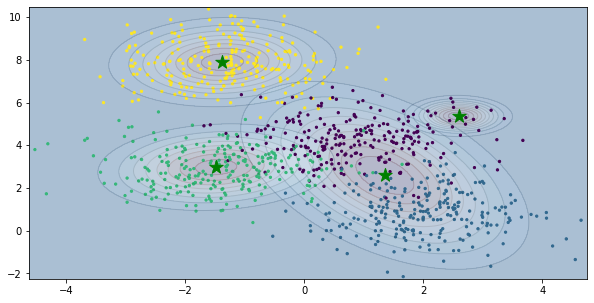

In [50]:
# GMM with random params initialization 
res_gmm(gmm, x, y, k, initial = 'random', iterations = 100)

-> Iterations untill convergence: 18

-> Métricas
· Confusion matrix:
 [[ 97 129  14  10]
 [  3   3 244   0]
 [244   2   3   1]
 [  3   0   0 247]]
· Error value = 0.136
· Clustering purity = 0.864
· F1 value = 0.8541816489142413

-> Elapsed time (in seconds): 0.5563764572143555


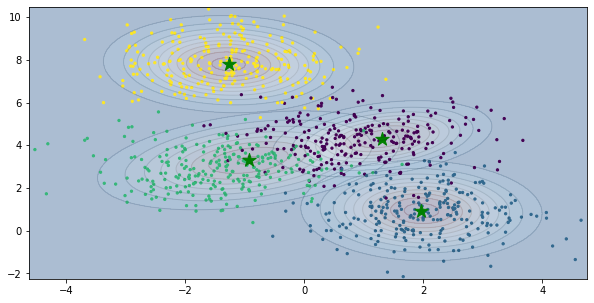

In [51]:
# GMM with random params initialization and Deterministic Anti-Annealing Expectation-Maximization
betas = [0.6, 0.8, 1.0, 1.2, 1.0]
res_gmm(gmm, x, y, k, initial = 'random', iterations = 100, betas=betas)

-> Iterations untill convergence: 5

-> Métricas
· Confusion matrix:
 [[  6  18 219   7]
 [  0   3   9 238]
 [  1 228  19   2]
 [244   0   6   0]]
· Error value = 0.07099999999999995
· Clustering purity = 0.9289999999999999
· F1 value = 0.9291003445759926

-> Elapsed time (in seconds): 0.1696937084197998


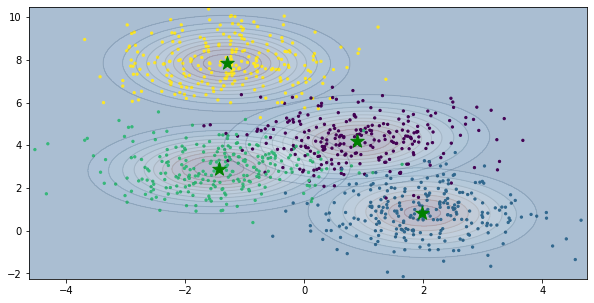

In [52]:
# GMM with Kmeans params initialization
res_gmm(gmm, x, y, k, initial = 'kmeans', iterations = 100)

-> Iterations untill convergence: 5

-> Métricas
· Confusion matrix:
 [[  7  18   6 219]
 [239   3   0   8]
 [  2 228   1  19]
 [  0   0 246   4]]
· Error value = 0.06799999999999995
· Clustering purity = 0.9319999999999999
· F1 value = 0.9319495563659995

-> Elapsed time (in seconds): 0.12521719932556152


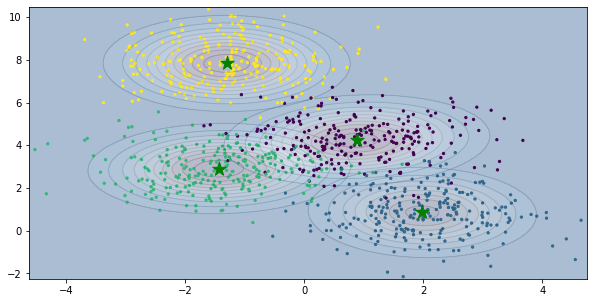

In [53]:
# GMM with Kmeans++ params initialization
res_gmm(gmm, x, y, k, initial = 'kmeans++', iterations = 100)

-> Iterations untill convergence: 5

-> Métricas
· Confusion matrix:
 [[  6   7 219  18]
 [  0 239   8   3]
 [  1   2  19 228]
 [246   0   4   0]]
· Error value = 0.06799999999999995
· Clustering purity = 0.932
· F1 value = 0.9319495563659995

-> Elapsed time (in seconds): 0.1297295093536377


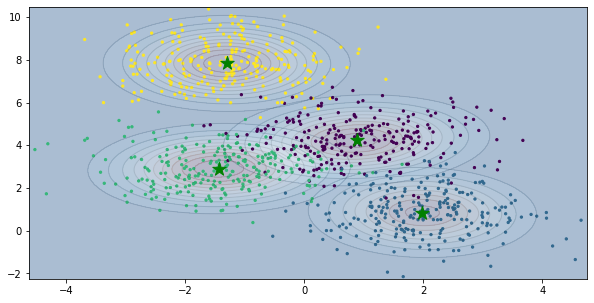

In [54]:
# GMM with PillarKmeans params initialization
res_gmm(gmm, x, y, k, initial = 'pillarkmeans', iterations = 100)

### Dataset 2

In [73]:
# Init GMM class
x = X2
y = Y2
k = 4
gmm = GMM(x, y, k)

-> Iterations untill convergence: 99

-> Métricas
· Confusion matrix:
 [[  231 10923   542   804]
 [    0   294 12027   179]
 [   55   946   219 11280]
 [12244   206     0    50]]
· Error value = 0.07052000000000003
· Clustering purity = 0.92948
· F1 value = 0.929297999930881

-> Elapsed time (in seconds): 131.6088318824768


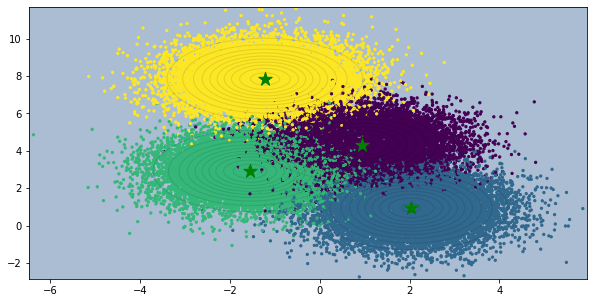

In [56]:
# GMM with random params initialization 
res_gmm(gmm, x, y, k, initial = 'random', iterations = 100)

-> Iterations untill convergence: 77

-> Métricas
· Confusion matrix:
 [[  215  9788  2060   437]
 [    0   312   300 11888]
 [   44   292 12009   155]
 [12226   177    97     0]]
· Error value = 0.08177999999999996
· Clustering purity = 0.91822
· F1 value = 0.9174326178039873

-> Elapsed time (in seconds): 97.56628155708313


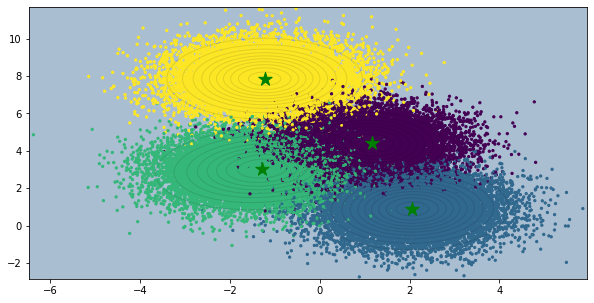

In [74]:
# GMM with random params initialization and Deterministic Anti-Annealing Expectation-Maximization
betas = [0.4, 0.6, 0.8, 1.0, 1.2, 1.0]
res_gmm(gmm, x, y, k, initial = 'random', iterations = 100, betas=betas)

-> Iterations untill convergence: 2

-> Métricas
· Confusion matrix:
 [[  976   181   397 10946]
 [  189     0 11895   416]
 [11458    47   191   804]
 [   60 12179     0   261]]
· Error value = 0.07043999999999995
· Clustering purity = 0.9295599999999999
· F1 value = 0.9296072400033216

-> Elapsed time (in seconds): 2.463905096054077


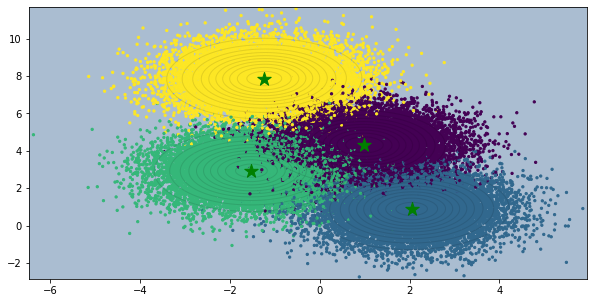

In [58]:
# GMM with Kmeans params initialization
res_gmm(gmm, x, y, k, initial = 'kmeans', iterations = 100)

-> Iterations untill convergence: 2

-> Métricas
· Confusion matrix:
 [[  182   875   411 11032]
 [    0   191 11900   409]
 [   45 11369   187   899]
 [12185    55     0   260]]
· Error value = 0.07028000000000001
· Clustering purity = 0.9297199999999999
· F1 value = 0.9298118403007868

-> Elapsed time (in seconds): 2.414303779602051


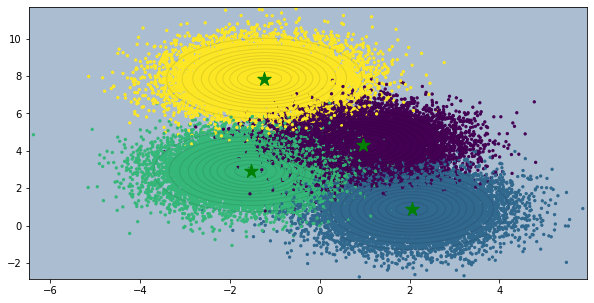

In [59]:
# GMM with Kmeans++ params initialization
res_gmm(gmm, x, y, k, initial = 'kmeans++', iterations = 100)

-> Iterations untill convergence: 3

-> Métricas
· Confusion matrix:
 [[  214   427   861 10998]
 [    0 11918   191   391]
 [   52   188 11357   903]
 [12231     0    52   217]]
· Error value = 0.06991999999999998
· Clustering purity = 0.93008
· F1 value = 0.9300708724220436

-> Elapsed time (in seconds): 4.157798767089844


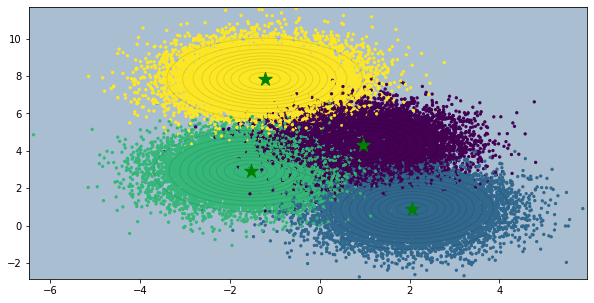

In [60]:
# GMM with PillarKmeans params initialization
res_gmm(gmm, x, y, k, initial = 'pillarkmeans', iterations = 100)

### **Dataset 3**

In [75]:
# Init GMM class
x = X3
y = Y3
k = 6
gmm = GMM(x, y, k)

-> Iterations untill convergence: 49

-> Métricas
· Confusion matrix:
 [[  89   66    1   31 1480    0]
 [  10 1560   44    0   53    0]
 [1479   44    0    4  140    0]
 [   8    0    0 1630   29    0]
 [   0    0   13    0    0 1653]
 [   0   65 1590    0    0   11]]
· Error value = 0.060799999999999965
· Clustering purity = 0.9392
· F1 value = 0.9392877369677253

-> Elapsed time (in seconds): 18.9668025970459


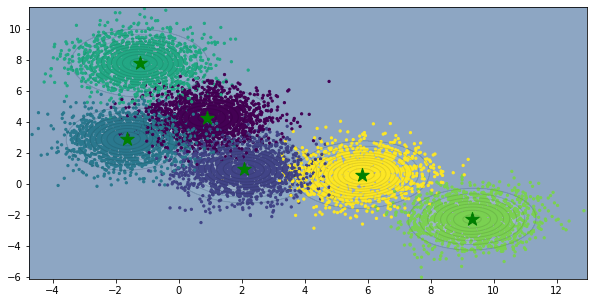

In [62]:
# GMM with random params initialization 
res_gmm(gmm, x, y, k, initial = 'random', iterations = 100)

-> Iterations untill convergence: 30

-> Métricas
· Confusion matrix:
 [[1428    2    1    0  235    1]
 [ 197  360    0    0 1110    0]
 [  77    0    0    0 1589    1]
 [ 147    0    0    0   15 1505]
 [   0   27    0 1639    0    0]
 [   2 1653    1    8    2    0]]
· Error value = 0.10760000000000003
· Clustering purity = 0.7815
· F1 value = 0.8016523485964699

-> Elapsed time (in seconds): 11.476979494094849


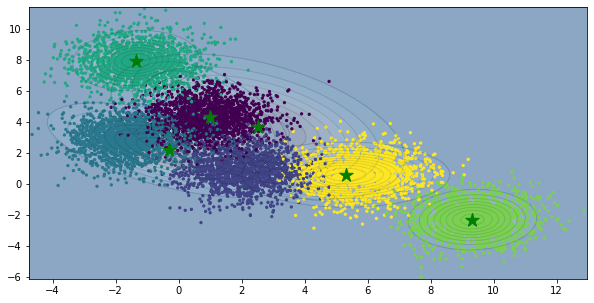

In [76]:
# GMM with random params initialization and Deterministic Anti-Annealing Expectation-Maximization
betas = [0.6, 0.8, 1.0, 1.2, 1.0]
res_gmm(gmm, x, y, k, initial = 'random', iterations = 100, betas=betas)

-> Iterations untill convergence: 19

-> Métricas
· Confusion matrix:
 [[  56    0   32    1    0 1578]
 [1527    0    0   53    0   87]
 [  27    0    2    0    0 1638]
 [   0    0 1628    0    0   39]
 [   0  678    0   11  977    0]
 [  55   14    0 1596    0    1]]
· Error value = 0.10560000000000003
· Clustering purity = 0.8044
· F1 value = 0.8128601578975407

-> Elapsed time (in seconds): 6.907058238983154


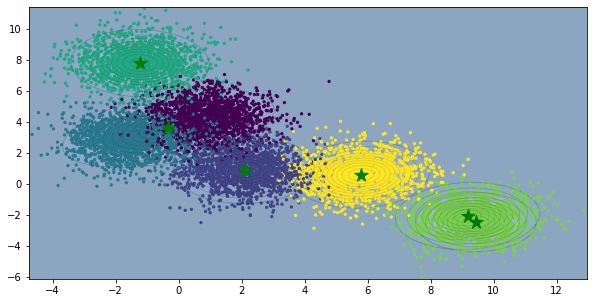

In [64]:
# GMM with Kmeans params initialization
res_gmm(gmm, x, y, k, initial = 'kmeans', iterations = 100)

-> Iterations untill convergence: 2

-> Métricas
· Confusion matrix:
 [[1498    0   24    1   99   45]
 [  70    0    0   54   17 1526]
 [ 133    0    4    0 1503   27]
 [  35    0 1623    0    9    0]
 [   0 1654    0   12    0    0]
 [   1   12    0 1600    0   53]]
· Error value = 0.059599999999999986
· Clustering purity = 0.9403999999999999
· F1 value = 0.9405689749196088

-> Elapsed time (in seconds): 0.7309508323669434


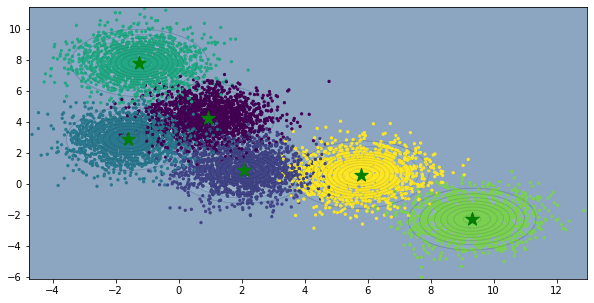

In [65]:
# GMM with Kmeans++ params initialization
res_gmm(gmm, x, y, k, initial = 'kmeans++', iterations = 100)

-> Iterations untill convergence: 3

-> Métricas
· Confusion matrix:
 [[   0   26   46 1500    1   94]
 [   0    0 1526   69   56   16]
 [   0    4   31  136    0 1496]
 [   0 1625    0   34    0    8]
 [1653    0    0    0   13    0]
 [  11    0   51    1 1603    0]]
· Error value = 0.059699999999999975
· Clustering purity = 0.9402999999999999
· F1 value = 0.9404501756356547

-> Elapsed time (in seconds): 2.1152663230895996


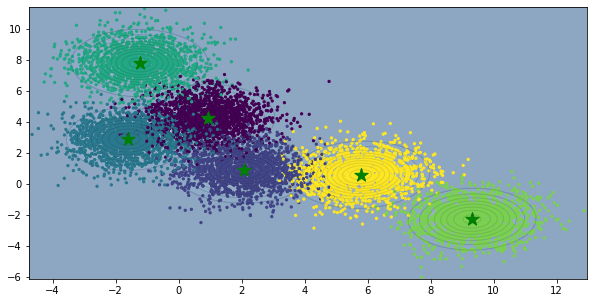

In [66]:
# GMM with PillarKmeans params initialization
res_gmm(gmm, x, y, k, initial = 'pillarkmeans', iterations = 100)

### **Dataset 4**

In [77]:
# Init GMM class
x = X4
y = Y4
k = 6
gmm = GMM(x, y, k)

-> Iterations untill convergence: 57

-> Métricas
· Confusion matrix:
 [[1661    0    0    6    0    0]
 [   0    0    0   89   16 1562]
 [   0    0    0 1599    0   68]
 [   0 1514  152    1    0    0]
 [   3    0    0 1663    0    0]
 [   0    0    0    0    4 1662]]
· Error value = 0.03390000000000004
· Clustering purity = 0.6668000000000001
· F1 value = 0.7580246182445908

-> Elapsed time (in seconds): 20.87175726890564


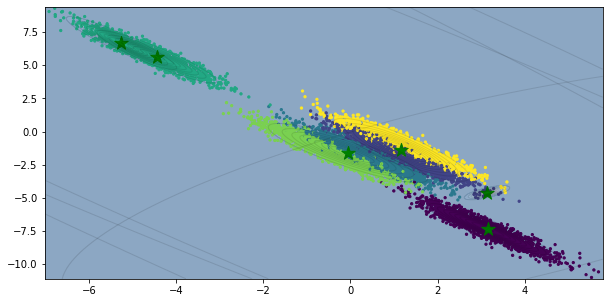

In [68]:
# GMM with random params initialization 
res_gmm(gmm, x, y, k, initial = 'random', iterations = 100)

-> Iterations untill convergence: 38

-> Métricas
· Confusion matrix:
 [[1662    0    0    5    0    0]
 [   0    0    0   93 1574    0]
 [   0    0    0 1604   63    0]
 [   0 1661    1    0    0    5]
 [   4    0    0 1662    0    0]
 [   0    0    0    0 1666    0]]
· Error value = 0.017100000000000004
· Clustering purity = 0.6656999999999998
· F1 value = 0.7663428394974313

-> Elapsed time (in seconds): 14.394828081130981


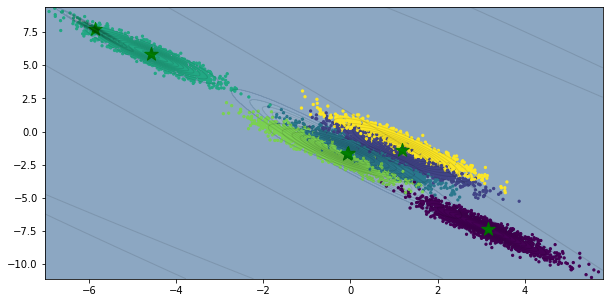

In [78]:
# GMM with random params initialization and Deterministic Anti-Annealing Expectation-Maximization
betas = [0.4, 0.6, 0.8, 1.0, 1.2, 1.0]
res_gmm(gmm, x, y, k, initial = 'random', iterations = 100, betas=betas)

-> Iterations untill convergence: 67

-> Métricas
· Confusion matrix:
 [[1185  475    0    0    7    0]
 [   0    0    0    0   89 1578]
 [   0    0    0    0 1598   69]
 [   0    0  144 1522    1    0]
 [   0    3    0    0 1663    0]
 [   0    0    0    0    0 1666]]
· Error value = 0.07879999999999998
· Clustering purity = 0.6655
· F1 value = 0.7310988957886777

-> Elapsed time (in seconds): 24.869898080825806


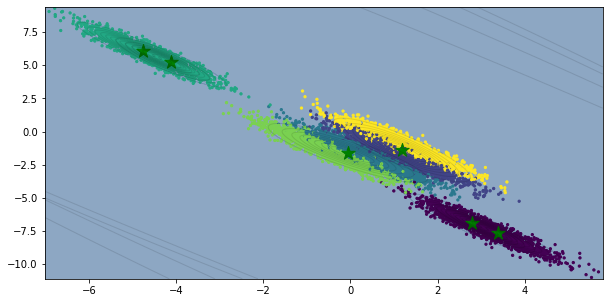

In [70]:
# GMM with Kmeans params initialization
res_gmm(gmm, x, y, k, initial = 'kmeans', iterations = 100)

-> Iterations untill convergence: 100

-> Métricas
· Confusion matrix:
 [[   0    2    0 1661    4    0]
 [  16  494    0    0    0 1157]
 [1014  455    0    1  184   13]
 [   1    0 1666    0    0    0]
 [ 114   13    0    5 1534    0]
 [   0    2    0    0    0 1664]]
· Error value = 0.13039999999999996
· Clustering purity = 0.8033
· F1 value = 0.8127493893083005

-> Elapsed time (in seconds): 38.43685793876648


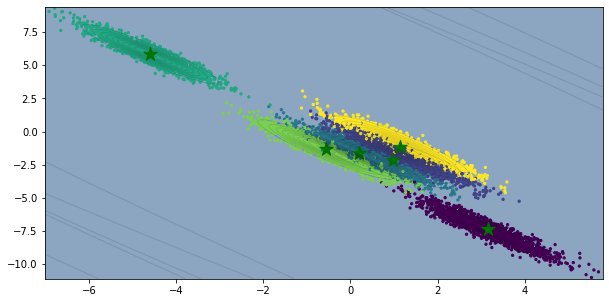

In [71]:
# GMM with Kmeans++ params initialization
res_gmm(gmm, x, y, k, initial = 'kmeans++', iterations = 100)

-> Iterations untill convergence: 56

-> Métricas
· Confusion matrix:
 [[   0 1661    0    6    0    0]
 [   0    0    0   89    0 1578]
 [   0    0    0 1598    0   69]
 [ 414    0  816    1  436    0]
 [   0    3    0 1663    0    0]
 [   0    0    0    0    0 1666]]
· Error value = 0.1018
· Clustering purity = 0.6656
· F1 value = 0.7093110162218405

-> Elapsed time (in seconds): 22.409844160079956


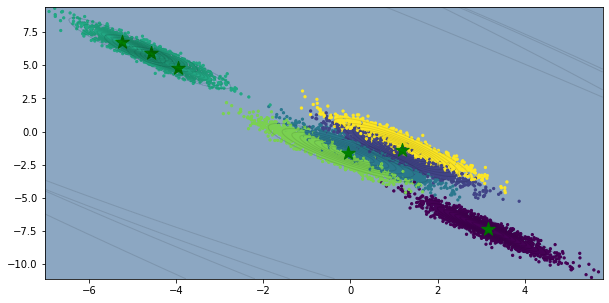

In [72]:
# GMM with PillarKmeans params initialization
res_gmm(gmm, x, y, k, initial = 'pillarkmeans', iterations = 100)

## Conclusions


As we can see, using the K-Means to initialize the EM-GMM algorithm improves the results a lot even with datasets that are usually not well handled but the K-Means alone, but with this combination can handle it better.

We can see this improvement in al K-means variants.
But then we also can see that the result can vary a bit depending on which K-means variant we use.

We have chosen to try 3 different variants of the K-means:

*   Vanilla K-Means
*   K-Means++
*   Pillar K-Means

Let's brifly describe every one of those modifications and analize the resoults we have in each of them.

#### Vanilla K-Means
This is the simplest version of K-Means that has it's centers initialized randomly.

Although it's simplicity generally in our datasets is the one that gives better results, but since the initialization is random we can not ensure that it will behave always as good.

#### K-Means++
This is an improvement over the Vanilla K-Means where we initialize the first centroid randomly and the nexts also randomly but with a higer probability to be choosen if they are further from the pervious centroids chosen.

Gives a similar result as the K-Means for our dataset, but generally will give better results and is more stable.

#### Pillar K-Means
Pillars algorithm basic idea is to point the centroids as far as possible from each other, is based on the idea of a house, where the pilars of it will be as far as possible from each other to stand the weigh on top of it.
So, this algorithm choses the positions of initial centroids by using the farthest accumulated distance between them.

Gives similar results as the K-Means++ but lasts more to initialize, as has to calculate all accumulated distances.

### Deterministic Anti-Annealing Expectation-Maximization:
Also we added another modification to the EM-GMM that is not related to the rest of the document, just to see how it works.
It is the Deterministic Anti-Annealing Expectation-Maximization, see the paper from we extracted the information in the Bibliography.

It basically tries to avoid the overlaping of the gaussian mixtures to make the convergence faster and it is supposed to make the algorithm more stable.

The DAEM basically changes the E-step using another formula to calculate the probabilities, so instead of using:

$$h_j (t) = \frac{α_jP(x_t|µ_j, Σ_j)}{\sum_{i=1}^{K}α_iP(x_t|µ_i, Σ_i)}$$

Will use:

$$h_j (t) = \frac{(α_jP(x_t|µ_j, Σ_j))^{\beta}}{\sum_{i=1}^{K}(α_iP(x_t|µ_i, Σ_i))^{\beta}}$$

And that beta will be initialized to a low number between 0 and 1, will increase until it's bigger than 1, and then decrease again until it is 1.

In the paper they get better results with: $betas = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.0]$ for their dataset, but in our datasets starting with a too low beta just makes the results really bad as the centers tend to go too much to the center so I used: $betas = [0.4, 0.6, 0.8, 1.0, 1.2, 1.0]$ With pretty good results.

It improves a lot compared to the Vanilla EM-GMM but the K-Means initialitzations generally give better results.

### Future improvements.
We could improve the Pillar K-Means to skip the calculations of the points that are near a centroid when it is chosen as is explained in this paper: [A Fast Algorithm for K-Means Optimization using Pillar Algorithm](https://www.researchgate.net/publication/274140037_A_Fast_Algorithm_for_K-Means_Optimization_using_Pillar_Algorithm)

We as well try to use the K-Meoids to see if it could improve the results in some datasets, as the principle is the same as the initialization of K-Means.



## Bibliography

### EM-GMM with K-Means initialization:
*   [Improved Gaussian mixture model with expectation-maximization for clustering of remote sensing imagery](https://ieeexplore.ieee.org/document/7729792)

#### Deterministic Anti-Annealing Expectation-Maximization:
*   [Convergence of the EM Algorithm for Gaussian Mixtures with
Unbalanced Mixing Coefficients](https://icml.cc/2012/papers/814.pdf)

#### Pillar K-Means:
*   [A pillar algorithm for K-means optimization by distance maximization for initial centroid designation](https://ieeexplore.ieee.org/document/4938630)
*   [A Fast Algorithm for K-Means Optimization using Pillar Algorithm](https://www.researchgate.net/publication/274140037_A_Fast_Algorithm_for_K-Means_Optimization_using_Pillar_Algorithm)
